In [18]:
import seaborn as sns
import numpy as np
import pandas as pd #Giarrusso vai a casa
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.signal as sig

In [2]:
vwce = yf.Ticker("VWCE.DE")

reference: https://pypi.org/project/yfinance/


In [3]:
vwce_ts = vwce.history(period="max")

In [4]:
vwce_ts.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Capital Gains'],
      dtype='object')

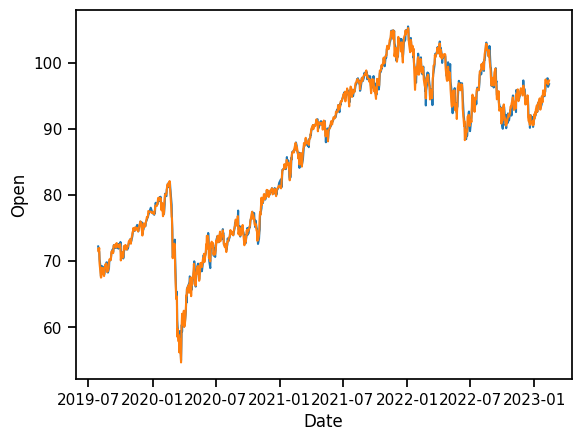

In [51]:
sns.lineplot(data=vwce_ts,x=vwce_ts.index,y='Open')
sns.lineplot(data=vwce_ts,x=vwce_ts.index,y='Close')

plt.show()

In [13]:
vwce_ts

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2019-07-29 00:00:00+02:00,72.220001,72.220001,71.849998,71.849998,351,0.0,0.0,0.0
2019-07-30 00:00:00+02:00,71.930000,71.959999,71.440002,71.440002,42,0.0,0.0,0.0
2019-07-31 00:00:00+02:00,71.419998,71.629997,71.419998,71.550003,37,0.0,0.0,0.0
2019-08-01 00:00:00+02:00,71.449997,72.010002,71.449997,71.989998,4340,0.0,0.0,0.0
2019-08-02 00:00:00+02:00,70.269997,70.279999,69.639999,69.639999,2401,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-02-07 00:00:00+01:00,97.000000,97.169998,96.820000,97.150002,69412,0.0,0.0,0.0
2023-02-08 00:00:00+01:00,97.680000,97.730003,96.959999,97.019997,75233,0.0,0.0,0.0
2023-02-09 00:00:00+01:00,97.660004,97.800003,97.169998,97.220001,57537,0.0,0.0,0.0


In [16]:
open_ts = vwce_ts['Open'].values

We tried the detrend, but introduces a decreasing trend in the last third of the timeseries, when the timeseries reaches a plateau.

So, in the next cells we will try to split the timeseries into smaller pieces and analyze them independently.
(we want to do a segmentation, like: https://www.sktime.org/en/latest/examples/annotation/segmentation_with_clasp.html)

In [19]:
detrend_open = sig.detrend(open_ts)

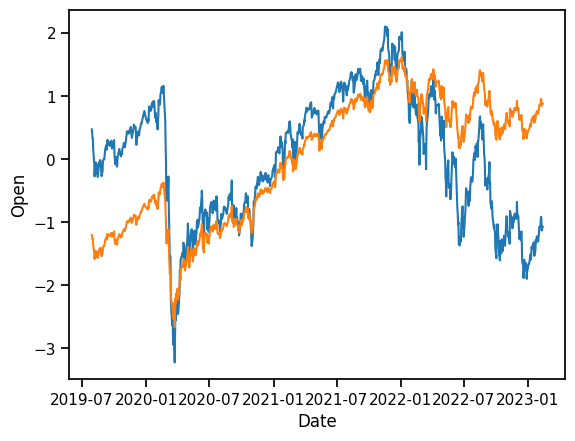

In [25]:
plt.plot(vwce_ts.index.values, (detrend_open-detrend_open.mean())/detrend_open.std())
sns.lineplot(data=(vwce_ts-vwce_ts.mean())/vwce_ts.std(),x=vwce_ts.index,y='Open')

plt.show()

In [32]:
descr_vwce = vwce_ts.describe()


In [35]:
descr_vwce

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
count,904.000000,904.000000,904.000000,904.000000,904.000000,904.0,904.0,904.0
mean,86.403628,86.844082,85.913960,86.387257,45620.074115,0.0,0.0,0.0
std,11.806028,11.832456,11.798955,11.810450,39790.733221,0.0,0.0,0.0
min,54.959999,57.330002,54.000000,54.660000,8.000000,0.0,0.0,0.0
25%,74.834997,75.070000,74.522499,74.827497,14800.250000,0.0,0.0,0.0
50%,90.494999,90.904999,90.099998,90.570000,38551.000000,0.0,0.0,0.0
75%,96.215000,96.870001,95.805002,96.240002,64979.000000,0.0,0.0,0.0
max,105.519997,105.839996,104.919998,105.279999,400494.000000,0.0,0.0,0.0


In [46]:
max_ts_idx = np.argmax(vwce_ts['Open'].values)
min_ts_idx = np.argmin(vwce_ts['Open'].values)
fasanese_max_ts_idx = np.argmax(vwce_ts['Open'].values[:200])

In [47]:
detrend_with_bp_open = sig.detrend(open_ts,bp = [fasanese_max_ts_idx,min_ts_idx,max_ts_idx])

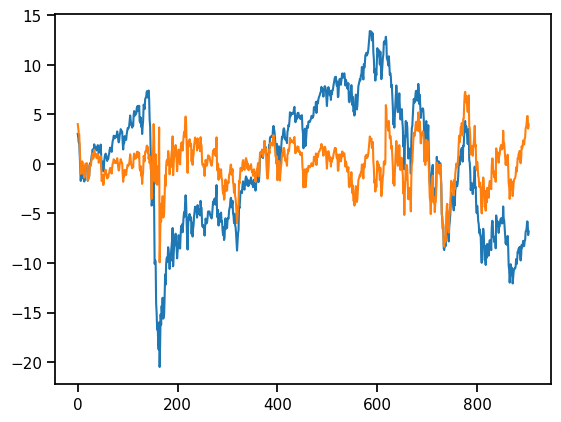

In [48]:
plt.plot(detrend_open)
plt.plot(detrend_with_bp_open)
plt.show()

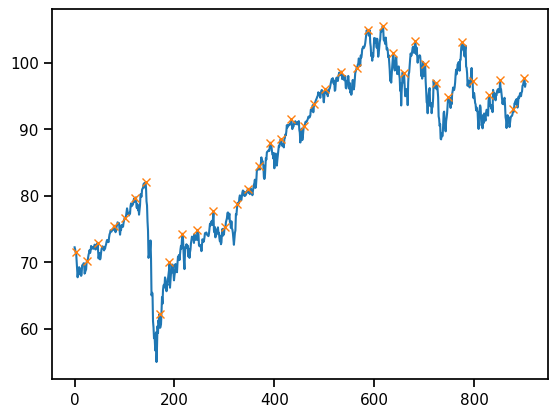

In [64]:
open_ts = vwce_ts['Open'].values

peaks, _ = sig.find_peaks(open_ts, distance=20)

plt.plot(open_ts)
plt.plot(peaks,open_ts[peaks],"x")
plt.show()


Segmentation with SKtime



In [65]:
sns.set_theme()
sns.set_color_codes()

from sktime.annotation.clasp import ClaSPSegmentation, find_dominant_window_sizes
from sktime.annotation.plotting.utils import (
    plot_time_series_with_change_points,
    plot_time_series_with_profiles,
)
from sktime.datasets import load_electric_devices_segmentation

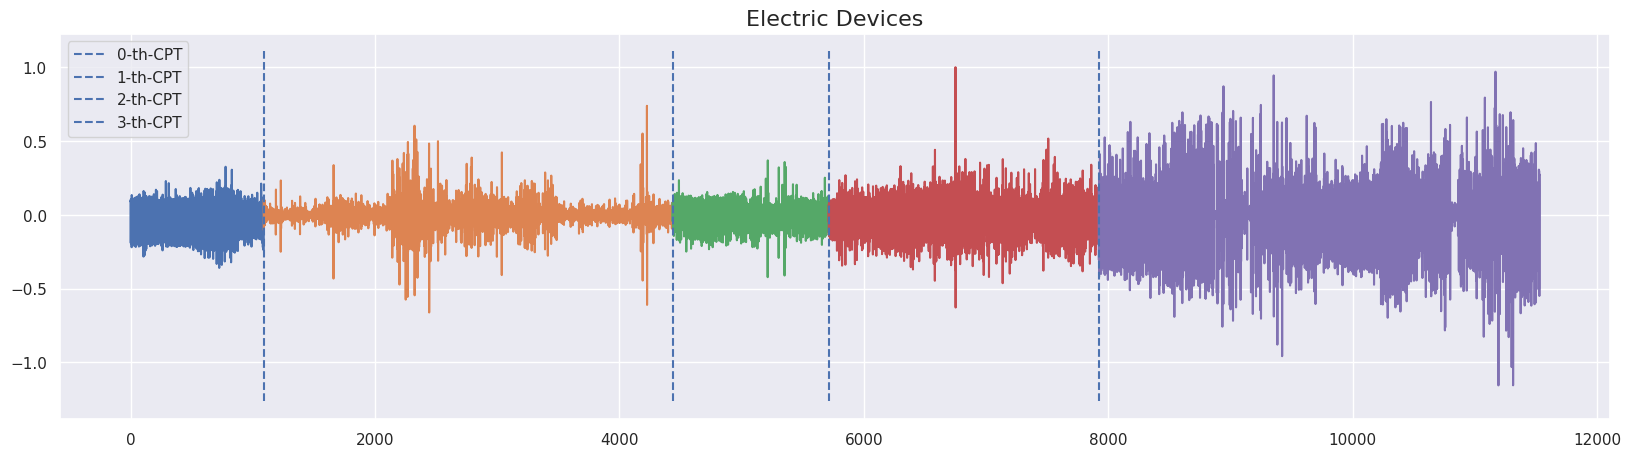

In [66]:
ts, period_size, true_cps = load_electric_devices_segmentation()
_ = plot_time_series_with_change_points("Electric Devices", ts, true_cps)
plt.show()

In [108]:
ts = vwce_ts['Open']
ts = (ts - ts.mean())/ts.std()


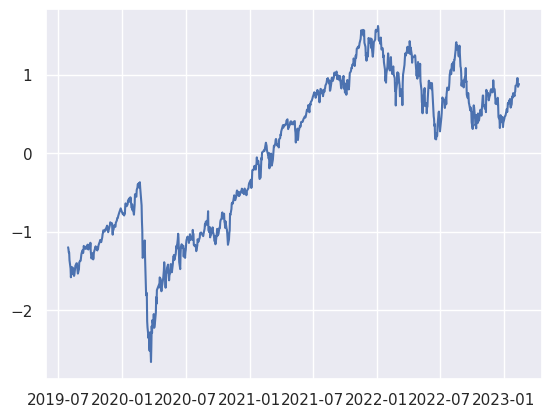

In [110]:
plt.plot(ts)
plt.show()

In [78]:
pd_ts = pd.DataFrame(ts)

In [112]:
dominant_period_size = find_dominant_window_sizes(ts)
print("Dominant Period", dominant_period_size)

Dominant Period 19


In [104]:
def plot_points(x, ts=open_ts):
    plt.plot(open_ts)
    plt.plot(x,open_ts[x],"x")
    plt.show()


In [113]:
clasp = ClaSPSegmentation(period_length=dominant_period_size, n_cps=10, fmt="sparse")
found_cps = clasp.fit_predict(ts)
profiles = clasp.profiles
scores = clasp.scores
print("The found change points are", found_cps.to_numpy())

The found change points are [572 676]


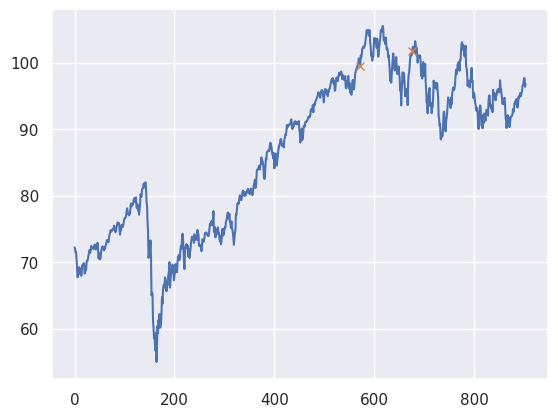

In [114]:
plot_points(found_cps.to_numpy())

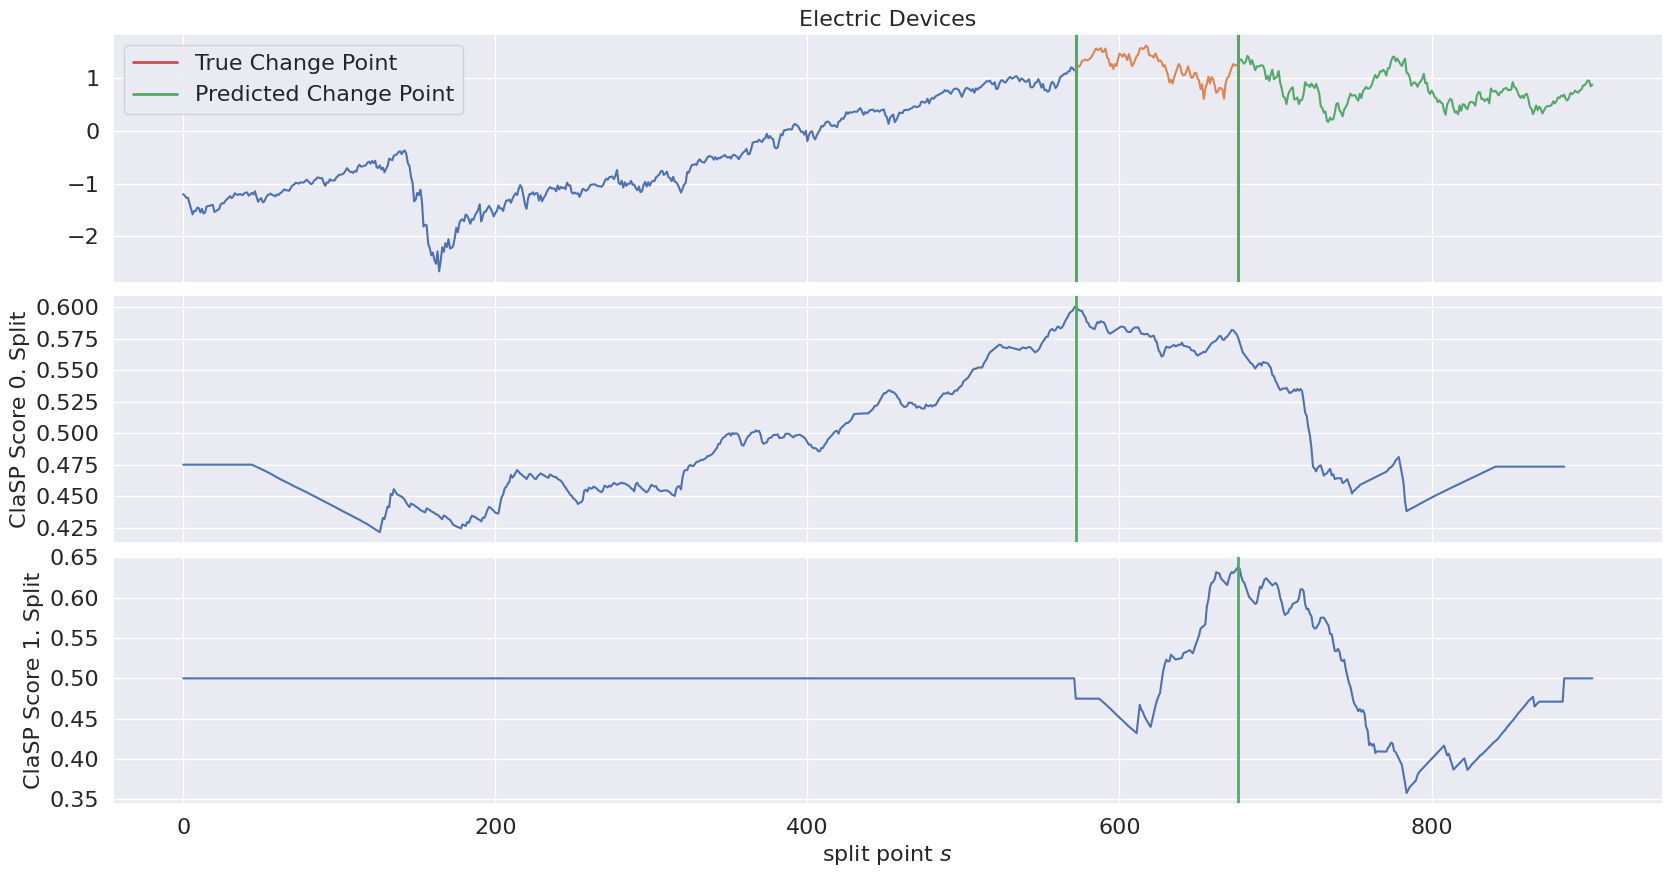

In [115]:
_ = plot_time_series_with_profiles(
    "Electric Devices",
    ts,
    profiles,
    found_cps,
    found_cps,
)
plt.show()

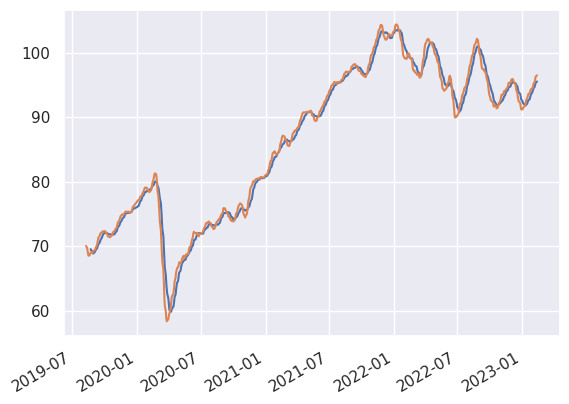

In [101]:
vwce_ts['Open'].rolling(19).mean().plot()
vwce_ts['Open'].rolling(10).mean().plot()
plt.show()


Info on clasp: 
https://www2.informatik.hu-berlin.de/~schaefpa/clasp.pdf

Timestamp('2019-07-29 00:00:00+0200', tz='Europe/Berlin')

In [128]:
days = (vwce_ts.index - vwce_ts.index[0]).days

In [129]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle(days,vwce_ts['Open'].values).autopower()

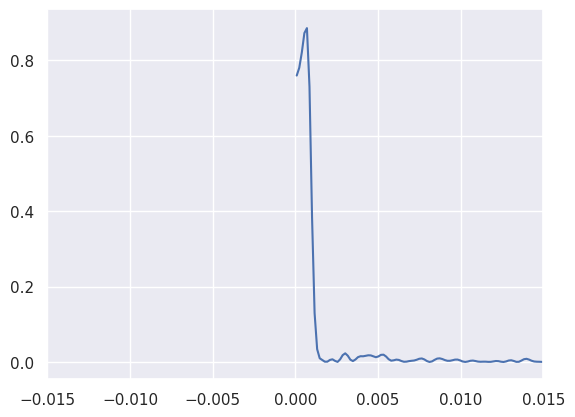

In [135]:
plt.plot(frequency, power)  
#plt.yscale('log')
plt.xlim(-0.015,0.015)
plt.show()     


In [169]:
x = np.arange(100,step=0.02)
y = 5*np.sin(x/5)+np.random.uniform(0,1, size=x.__len__())
frequency, power = LombScargle(x,y).autopower()

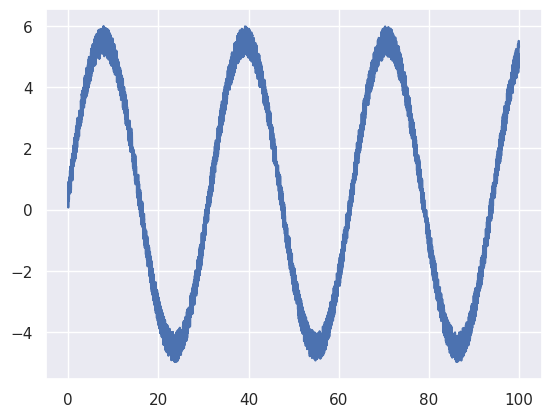

In [170]:
plt.plot(x, y)

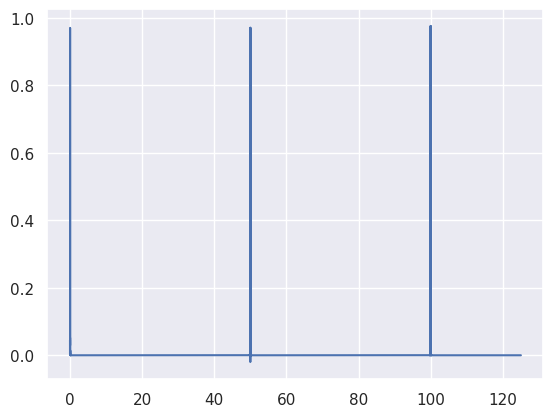

In [171]:
plt.plot(frequency, power)
# plt.yscale('log')
plt.show()     

